# Colorization using Perceptual Loss

Style Transfer using "Perceptual Losses for Real-Time Style Transfer and Super-Resolution" by Justin et.al
http://arxiv.org/abs/1603.08155
 

 
input  lowRes photo  ->  CNN   -> HiRes photo output  
loss function calculates the content loss between loRes and hiRes  
perceptual loss = MSE between activations of 2 images (JH was calling it content loss)

can use for denoising, SR, colorization (grayscale -> color)  
Generative Image  = Image In -> Image Out

#### **General Concept**

1 network to put grayscale into and out comes color (the trainable net)
1 vgg to get activations on ground truth hires image (not trainable)  using block2_conv2  
1 vgg to get activation on image made by upsampling (not trainable)  basically same network as above  
take MSE loss of each vgg  
optimize the color creator network to reduce the combined loss  
target for loss so make it zeros  

finalmodel (lowres, vgg, loss)

fitting 
Keras needs to match a loss to target so make an array of zeros
compile with adam and mse

Eventually the only model we care about is our upsampling model

### Architecture

inp = Input(inp_shape)  
x = conv_block(inp,64,9,(1,1)  - this is 1x1 convolutions creating 64 filters, filter size=9 - this allows us to increase the receptive field  - common in modern CNNs (stride 1,1) doesn't through away any info

4 res_block - the computation this is the key work. 
resnet 2 convs on the input then adds that back to the original (no activation on last conv)

In generative models we want to do the computation at a low level
 - at low level there is less work to do so its faster
 - at low level we have a bigger receptive field so we can recognize stuff fast - eg. 3x3 give 3x3 recptive field depending on how deep you are
 - down sampling can increase receptive field
 
 conv_block = Conv + BatchNorm + activation

# TTD

1. learn to make bcolz with 1k images  - done
2. Get network working for 4x
3. Make network 8x

# Goal

1. make a dataset with the celebfaces - Done
2. make 8x resolution - 36 ->72->144->288


# Key Questions

1. is the 72px image resized to fit into the 224 VGG network? same for the 288 image
2. how do the keras inputs work?
3. Why do we use bcolz array? - saves time having to process images each time/ saves space on disk/ is fastest np arrays
4. how to see the network shapes etc for VGG nd other models

### Imports

In [1]:
%matplotlib inline
import importlib
from scipy.misc import imread, imresize, imsave, fromimage, toimage
from scipy.optimize import fmin_l_bfgs_b
import numpy as np
import time
import random
from PIL import Image
import os
import pickle
import bcolz
from bcolz_array_iterator import BcolzArrayIterator
import matplotlib.pyplot as plt

import tensorflow as tf
import keras
from keras.models import Model
from keras.layers import Input
from keras.layers.convolutional import Convolution2D, AveragePooling2D, MaxPooling2D
from keras import backend as K
from keras.utils.data_utils import get_file
from keras.utils.layer_utils import convert_all_kernels_in_model
import keras.backend as K

from vgg16_avg import VGG16_Avg

import sys
#sys.path.append('../utilities')
import utils2; importlib.reload(utils2)
from utils2 import *

Using TensorFlow backend.


### SDK Versions


In [2]:
print('TensorFlow:',tf.__version__)
print('Keras:',keras.__version__)

limit_mem()
#%cd /Users/samwitteveen/dropbox/ai_learning/fastai/part_2/lesson10
#!pwd

TensorFlow: 1.0.1
Keras: 1.2.2


### Celeb Faces

In [4]:
def save_array(fname, arr): c=bcolz.carray(arr, rootdir=fname, mode='w'); c.flush()
def load_array(fname): return bcolz.open(fname)[:]

gray = arr_gray
norm = arr_color

In [8]:
dpath = '/home/samwit/ai_data_local/celeba_bcolz'
#dpath = '/home/samwit/Dropbox/ai_learning/Key DL Learning'
bcolz_hr = '/celeba-176_hr_50k.bc'
bcolz_lr = '/celeba-44_2k.bc'
bcolz_grayscale = '/celeba-grayscale_50k.bc'
bcolz_test_lr = '/celeba-44_test.bc'
bcolz_test_hr = '/celeba-176_test.bc'


#arr_gray = load_array(dpath+bcolz_grayscale)
#arr_color = load_array(dpath+bcolz_hr)
#arr_test_hr = load_array(dpath+bcolz_test_hr)
#arr_test_lr = load_array(dpath+bcolz_test_lr)

arr_gray = bcolz.open(dpath+bcolz_grayscale)
arr_color = bcolz.open(dpath+bcolz_hr)

arr_gray.shape

(50000, 176, 176, 3)

### Make a U-net

In [9]:
def conv_block(x, filters, size, stride=(2,2), mode='same', act=True):
    x = Convolution2D(filters, size, size, subsample=stride, border_mode=mode)(x)
    x = BatchNormalization(mode=2)(x)
    return Activation('relu')(x) if act else x

def res_block(ip, nf=64):
    x = conv_block(ip, nf, 3, (1,1))
    x = conv_block(x, nf, 3, (1,1), act=False)
    return merge([x, ip], mode='sum')

In [10]:
def colorization_net(arr):
    inputs = Input(arr.shape[1:])
    conv1 = Conv2D(32, 3, 3, activation='relu', border_mode='same')(inputs)
    conv1 = Conv2D(32, 3, 3, activation='relu', border_mode='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    
    conv2 = Conv2D(64, 3, 3, activation='relu', border_mode='same')(pool1)
    conv2 = Conv2D(64, 3, 3, activation='relu', border_mode='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    
    conv3 = Conv2D(128, 3, 3, activation='relu', border_mode='same')(pool2)
    conv3 = Conv2D(128, 3, 3, activation='relu', border_mode='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    
    conv4 = Conv2D(256, 3, 3, activation='relu', border_mode='same')(pool3)
    conv4 = Conv2D(256, 3, 3, activation='relu', border_mode='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
    
    up1 = UpSampling2D(size=(2, 2))(pool4)
    conv5 = Convolution2D(128, 2, 2, activation='relu', border_mode='same')(up1)
    
    up2 = UpSampling2D(size=(2, 2))(conv5)
    conv6 = Convolution2D(64, 2, 2, activation='relu', border_mode='same')(up2)
    
    up3 = UpSampling2D(size=(2, 2))(conv6)
    conv7 = Convolution2D(33, 2, 2, activation='relu', border_mode='same')(up3)

    up4 = UpSampling2D(size=(2, 2))(conv7)
    conv8 = Convolution2D(3, 2, 2, activation='relu', border_mode='same')(up4)
    
    #model = Model(input=inputs, output=conv8)
    outputs = conv8
    
    return inputs,outputs #model

In [11]:
bw_inputs,color_outputs = colorization_net(arr_gray)
color_model = Model(bw_inputs,color_outputs)
color_model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 176, 176, 3)   0                                            
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 176, 176, 32)  896         input_1[0][0]                    
____________________________________________________________________________________________________
convolution2d_2 (Convolution2D)  (None, 176, 176, 32)  9248        convolution2d_1[0][0]            
____________________________________________________________________________________________________
maxpooling2d_1 (MaxPooling2D)    (None, 88, 88, 32)    0           convolution2d_2[0][0]            
___________________________________________________________________________________________


#### Image Preproc and deproc

In [12]:
# vgg preproc
rn_mean = np.array([123.68, 116.779, 103.939], dtype=np.float32)
preproc = lambda x: (x - rn_mean)[:, :, :, ::-1]

# deproc
deproc = lambda x,s: np.clip(x.reshape(s)[:, :, :, ::-1] + rn_mean, 0, 255)

In [13]:
up_model = Lambda(colorization_net(arr_gray))
#bw_inputs,color_outputs = colorization_net(arr_gray)
#color_model = Model(bw_inputs,color_outputs)
#color_model.summary()

### VGG network

this is only used to for calculating our loss


In [14]:
#vgg input
vgg_inp=Input(arr_gray.shape[1:])

#vgg network
vgg= VGG16(include_top=False, input_tensor=vgg_inp)
for l in vgg.layers: l.trainable=False

#vgg.summary()


In [15]:
# Lambda makes a layer of a function/ this makes the preprocessing a layer
preproc_layer = Lambda(preproc)

In [16]:
# get the vgg output 
vgg_out_layer = vgg.get_layer('block2_conv2').output

# making model Model(inputs, outputs)
vgg_content = Model(vgg_inp, vgg_out_layer)

vgg_content.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_3 (InputLayer)             (None, 176, 176, 3)   0                                            
____________________________________________________________________________________________________
block1_conv1 (Convolution2D)     (None, 176, 176, 64)  1792        input_3[0][0]                    
____________________________________________________________________________________________________
block1_conv2 (Convolution2D)     (None, 176, 176, 64)  36928       block1_conv1[0][0]               
____________________________________________________________________________________________________
block1_pool (MaxPooling2D)       (None, 88, 88, 64)    0           block1_conv2[0][0]               
___________________________________________________________________________________________

In [17]:
# this is the VGG model with the HR input
vgg_hr_image = vgg_content(preproc_layer(vgg_inp))

# this is the 
vgg_it_op = vgg_content(preproc_layer(color_outputs))

### Loss and Optimisers


In [18]:
loss = Lambda(lambda x: K.sqrt(K.mean((x[0]-x[1])**2, (1,2))))([vgg_hr_image, vgg_it_op])

In [19]:
sr_model = Model([bw_inputs, vgg_inp], loss)
sr_model.compile('adam', 'mse')

### Training

In [20]:
#targ = np.zeros((arr_gray.shape[0], 128))
#sr_model.fit([ arr_gray,arr_color], targ, 8, 10)

### Batch Training

In [21]:
def train(bs, iterations=10):
    #targ = np.zeros((bs, 1))
    targ = np.zeros((bs, 128))
    bc = BcolzArrayIterator(arr_gray,arr_color,batch_size=bs)
    for i in range(iterations):
        if i%100==0:
            print('iteration:',i)
        lr,hr = next(bc)
        sr_model.train_on_batch([lr[:bs], hr[:bs]],targ)

In [22]:
its = len(arr_color)//16; its

3125

In [70]:
%time train(16,200000)

iteration: 0
iteration: 100
iteration: 200
iteration: 300
iteration: 400
iteration: 500
iteration: 600
iteration: 700
iteration: 800
iteration: 900
iteration: 1000
iteration: 1100
iteration: 1200
iteration: 1300
iteration: 1400
iteration: 1500
iteration: 1600
iteration: 1700
iteration: 1800
iteration: 1900
iteration: 2000
iteration: 2100
iteration: 2200
iteration: 2300
iteration: 2400
iteration: 2500
iteration: 2600
iteration: 2700
iteration: 2800
iteration: 2900
iteration: 3000
iteration: 3100
iteration: 3200
iteration: 3300
iteration: 3400
iteration: 3500
iteration: 3600
iteration: 3700
iteration: 3800
iteration: 3900
iteration: 4000
iteration: 4100
iteration: 4200
iteration: 4300
iteration: 4400
iteration: 4500
iteration: 4600
iteration: 4700
iteration: 4800
iteration: 4900
iteration: 5000
iteration: 5100
iteration: 5200
iteration: 5300
iteration: 5400
iteration: 5500
iteration: 5600
iteration: 5700
iteration: 5800
iteration: 5900
iteration: 6000
iteration: 6100
iteration: 6200
iter

### Saver


In [71]:
it_model = Model(bw_inputs, color_outputs)
it_model.save_weights('./weights/'+'celba_colorization_50k.h5')

In [72]:
it_model = Model(bw_inputs, color_outputs)
it_model.load_weights('./weights/'+'celba_colorization_50k.h5')

### Examples

show 1. low res 2. hi-res 3. ground truth


In [73]:
p = it_model.predict(arr_gray[0:50])
p.shape

(50, 176, 176, 3)

In [74]:
def compare_pics(x,y):
    fig = plt.figure(figsize=(40,40))
    a=fig.add_subplot(1,2,1)
    imgplot = plt.imshow(x)
    a=fig.add_subplot(1,2,2)
    imgplot = plt.imshow(y)

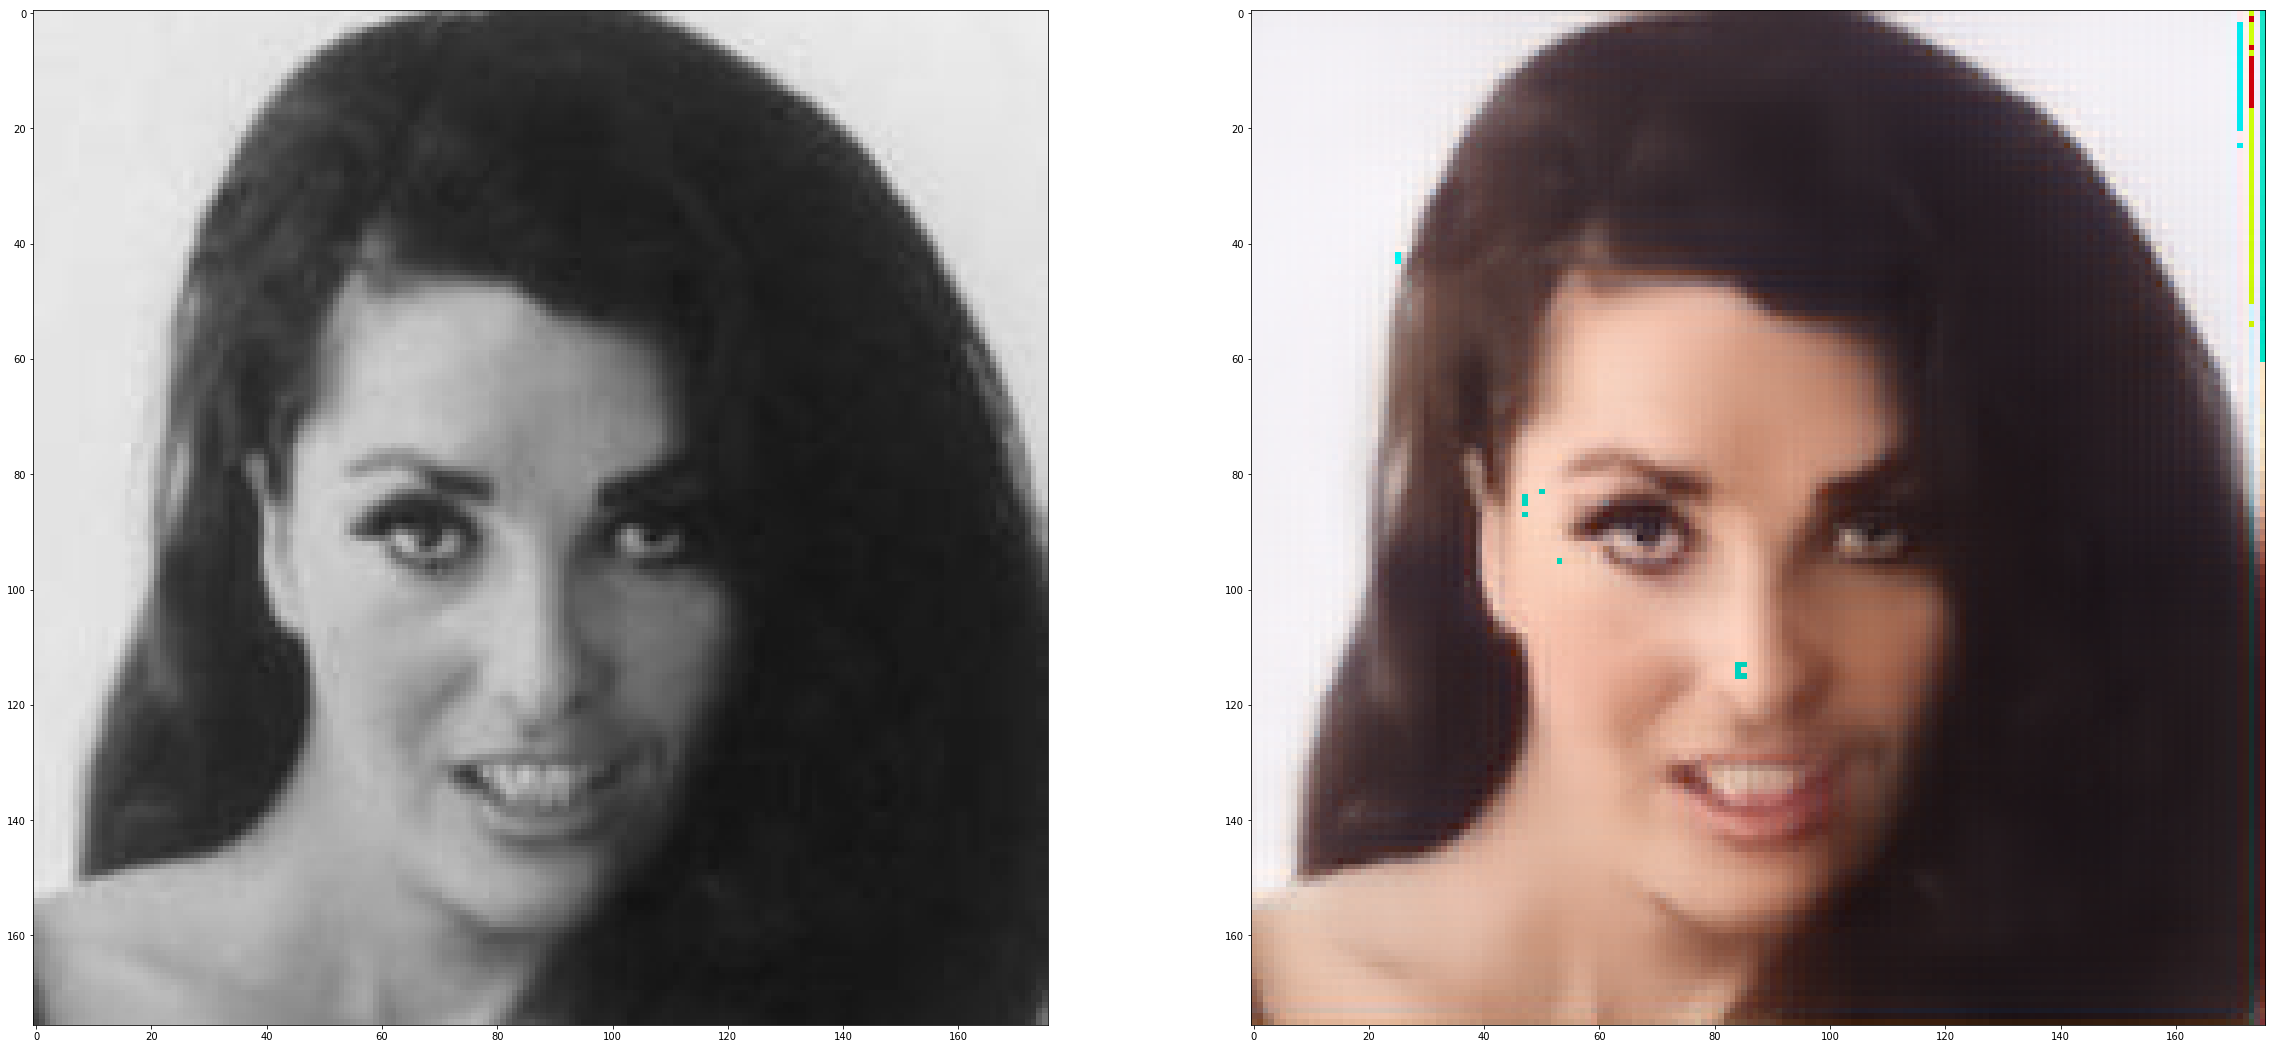

In [75]:
compare_pics(arr_gray[10].astype('uint8'), p[10].astype('uint8'))

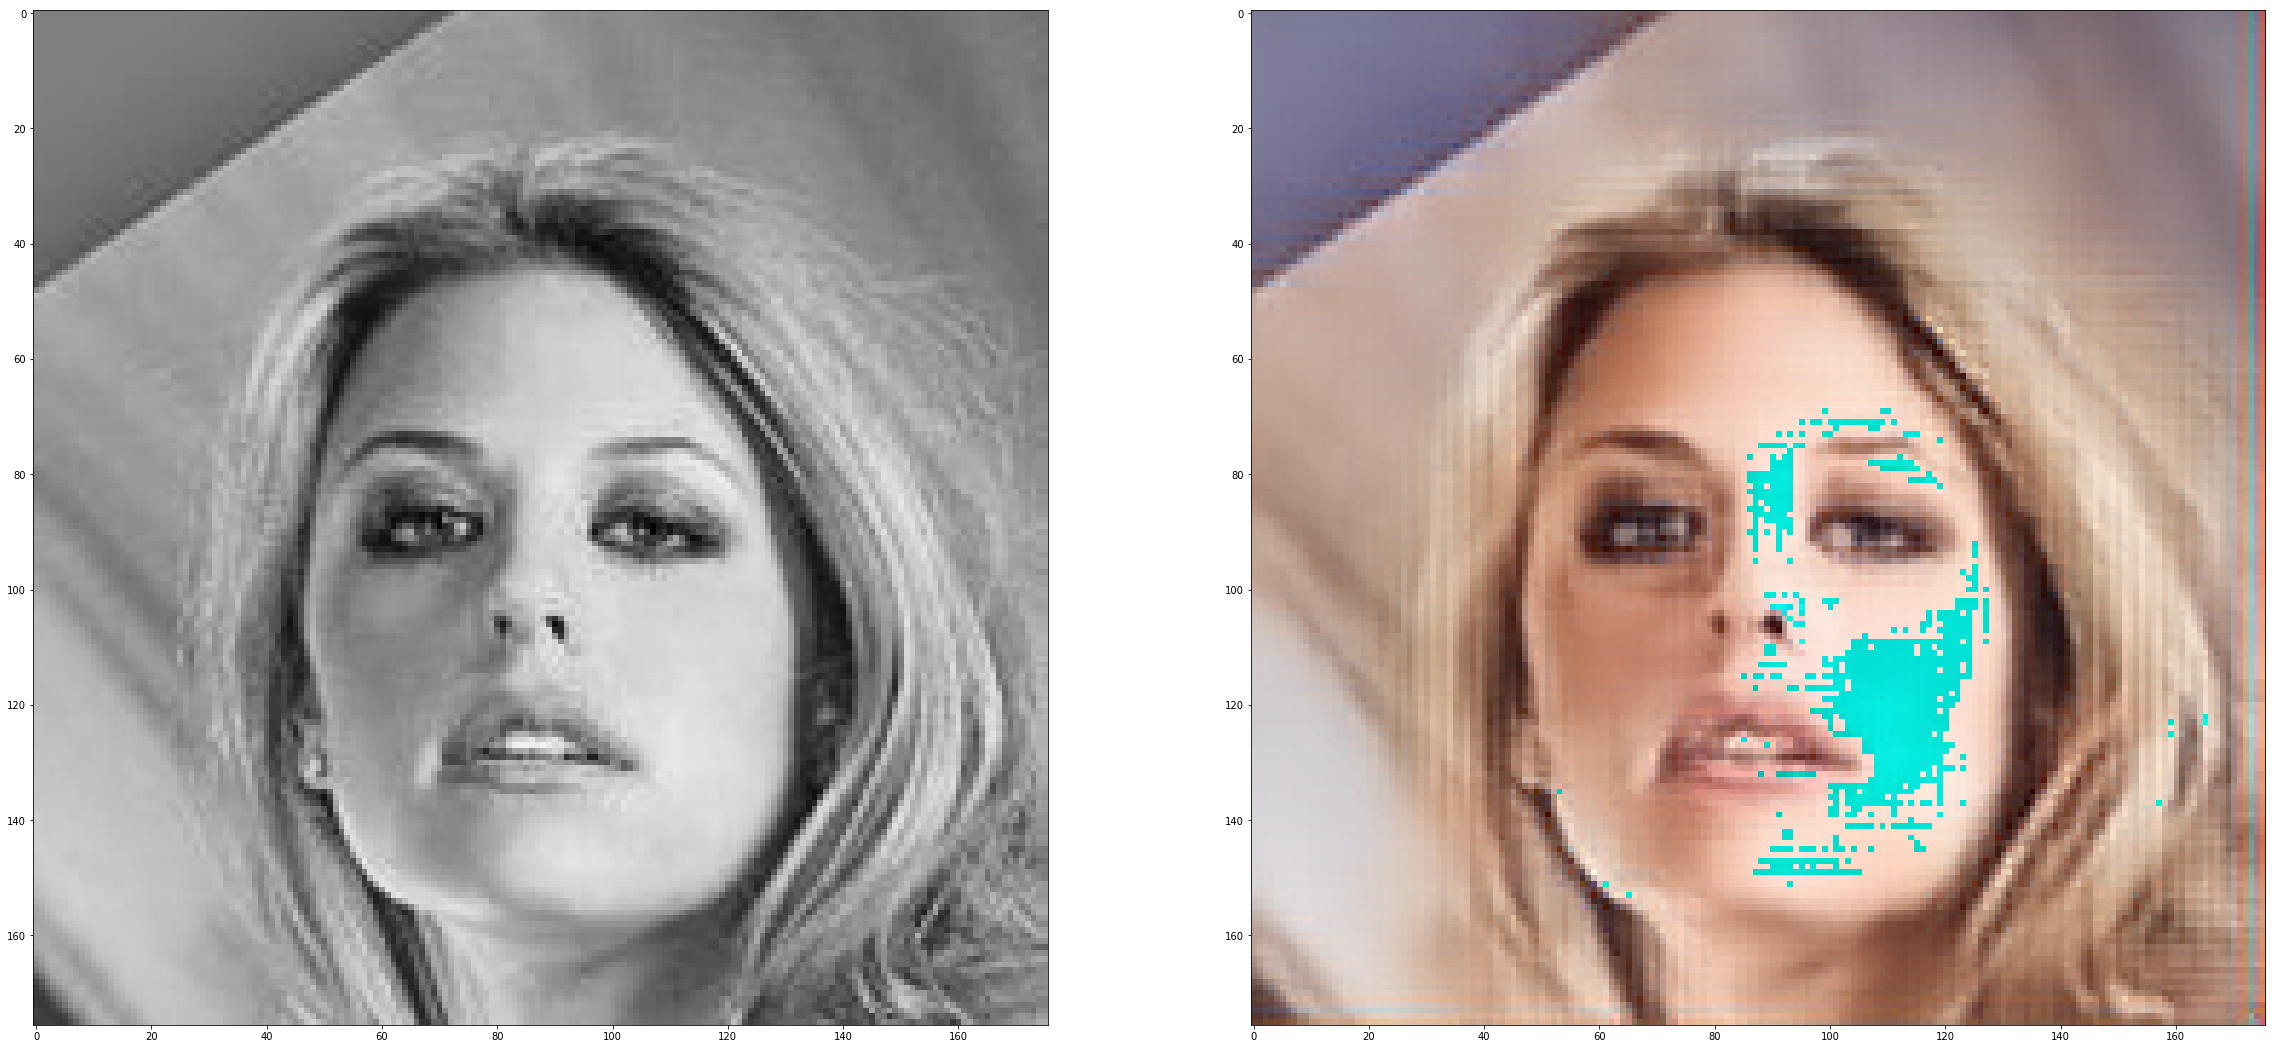

In [76]:
compare_pics(arr_gray[23].astype('uint8'), p[23].astype('uint8'))

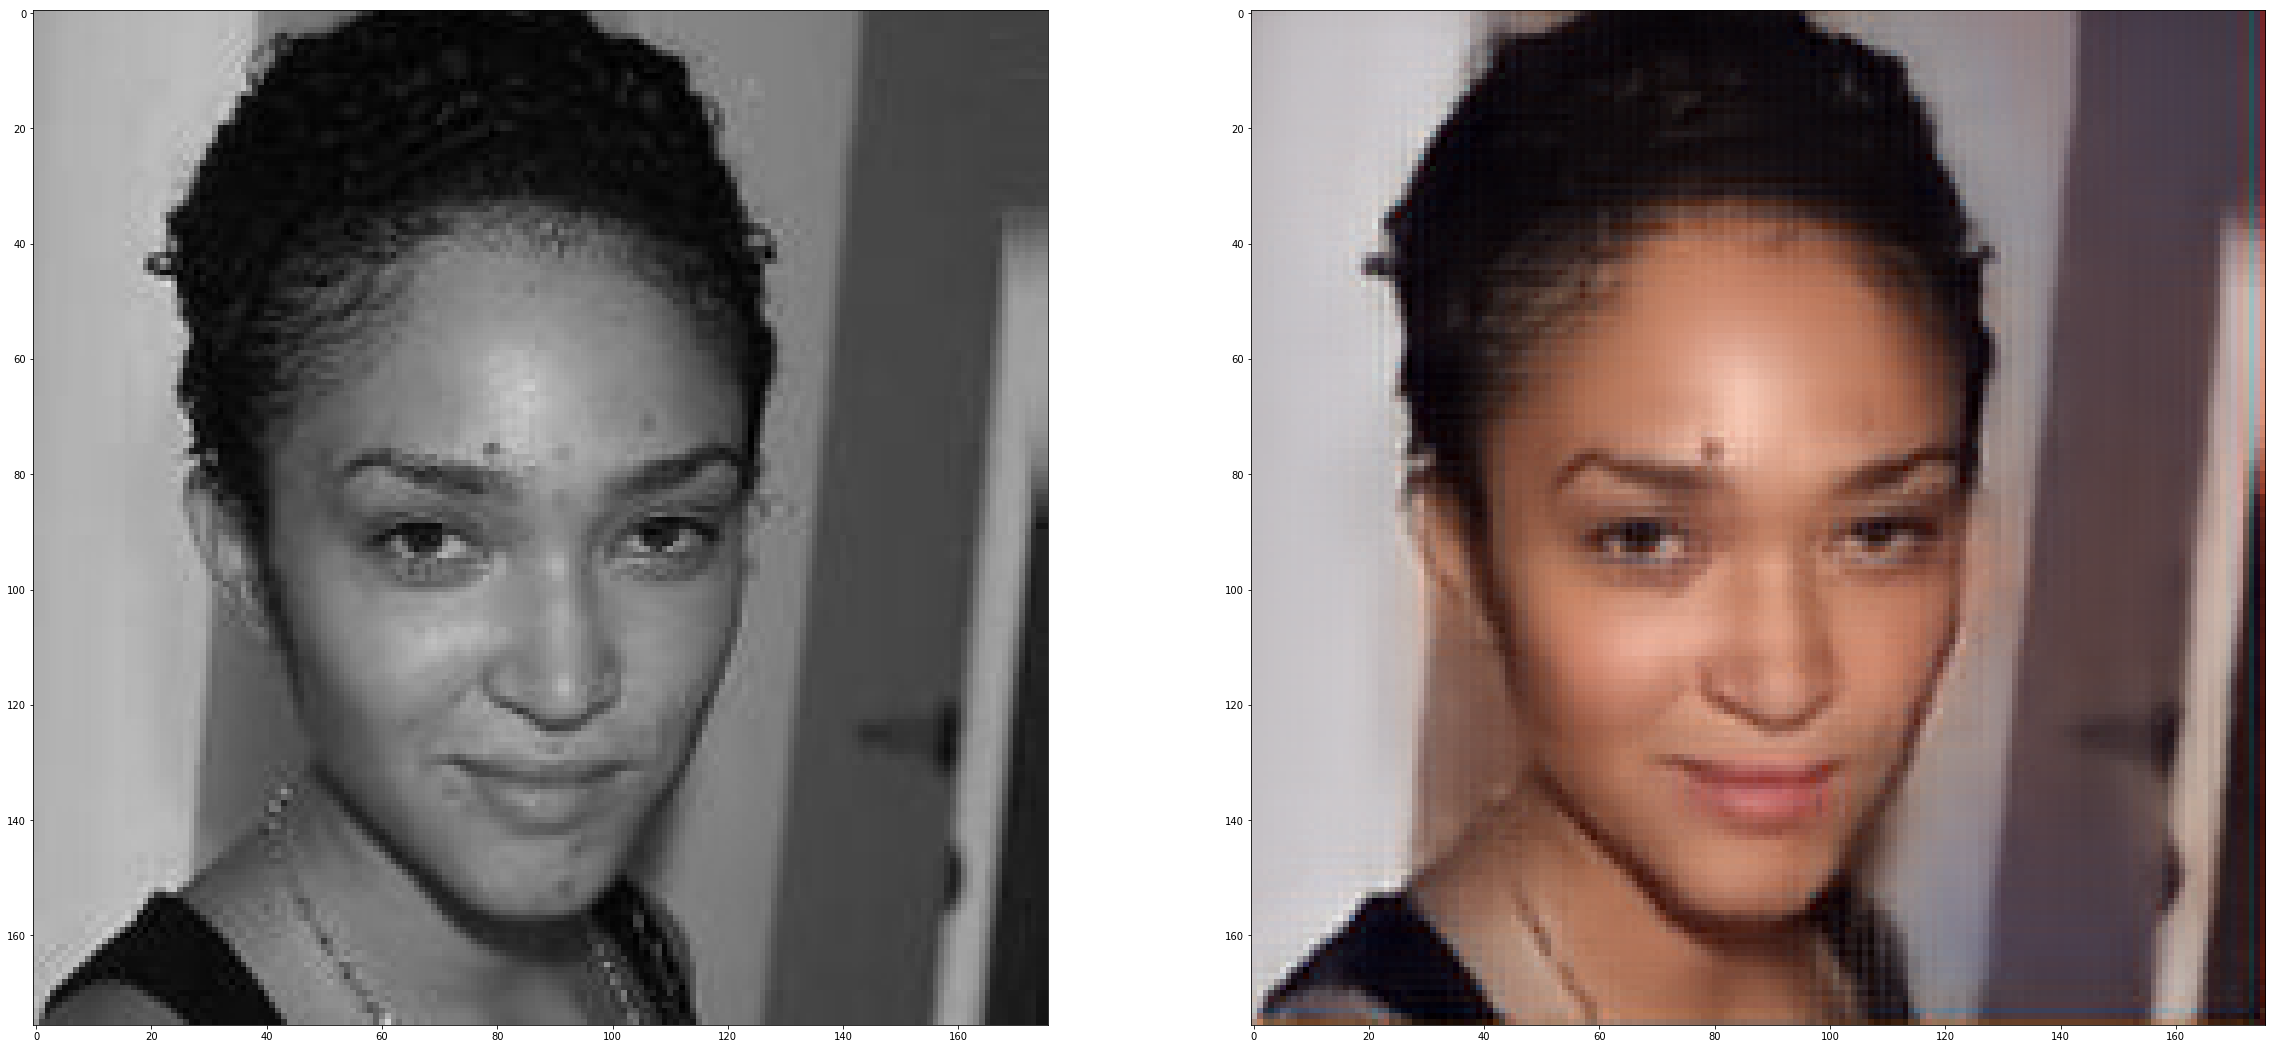

In [77]:
compare_pics(arr_gray[13].astype('uint8'), p[13].astype('uint8'))

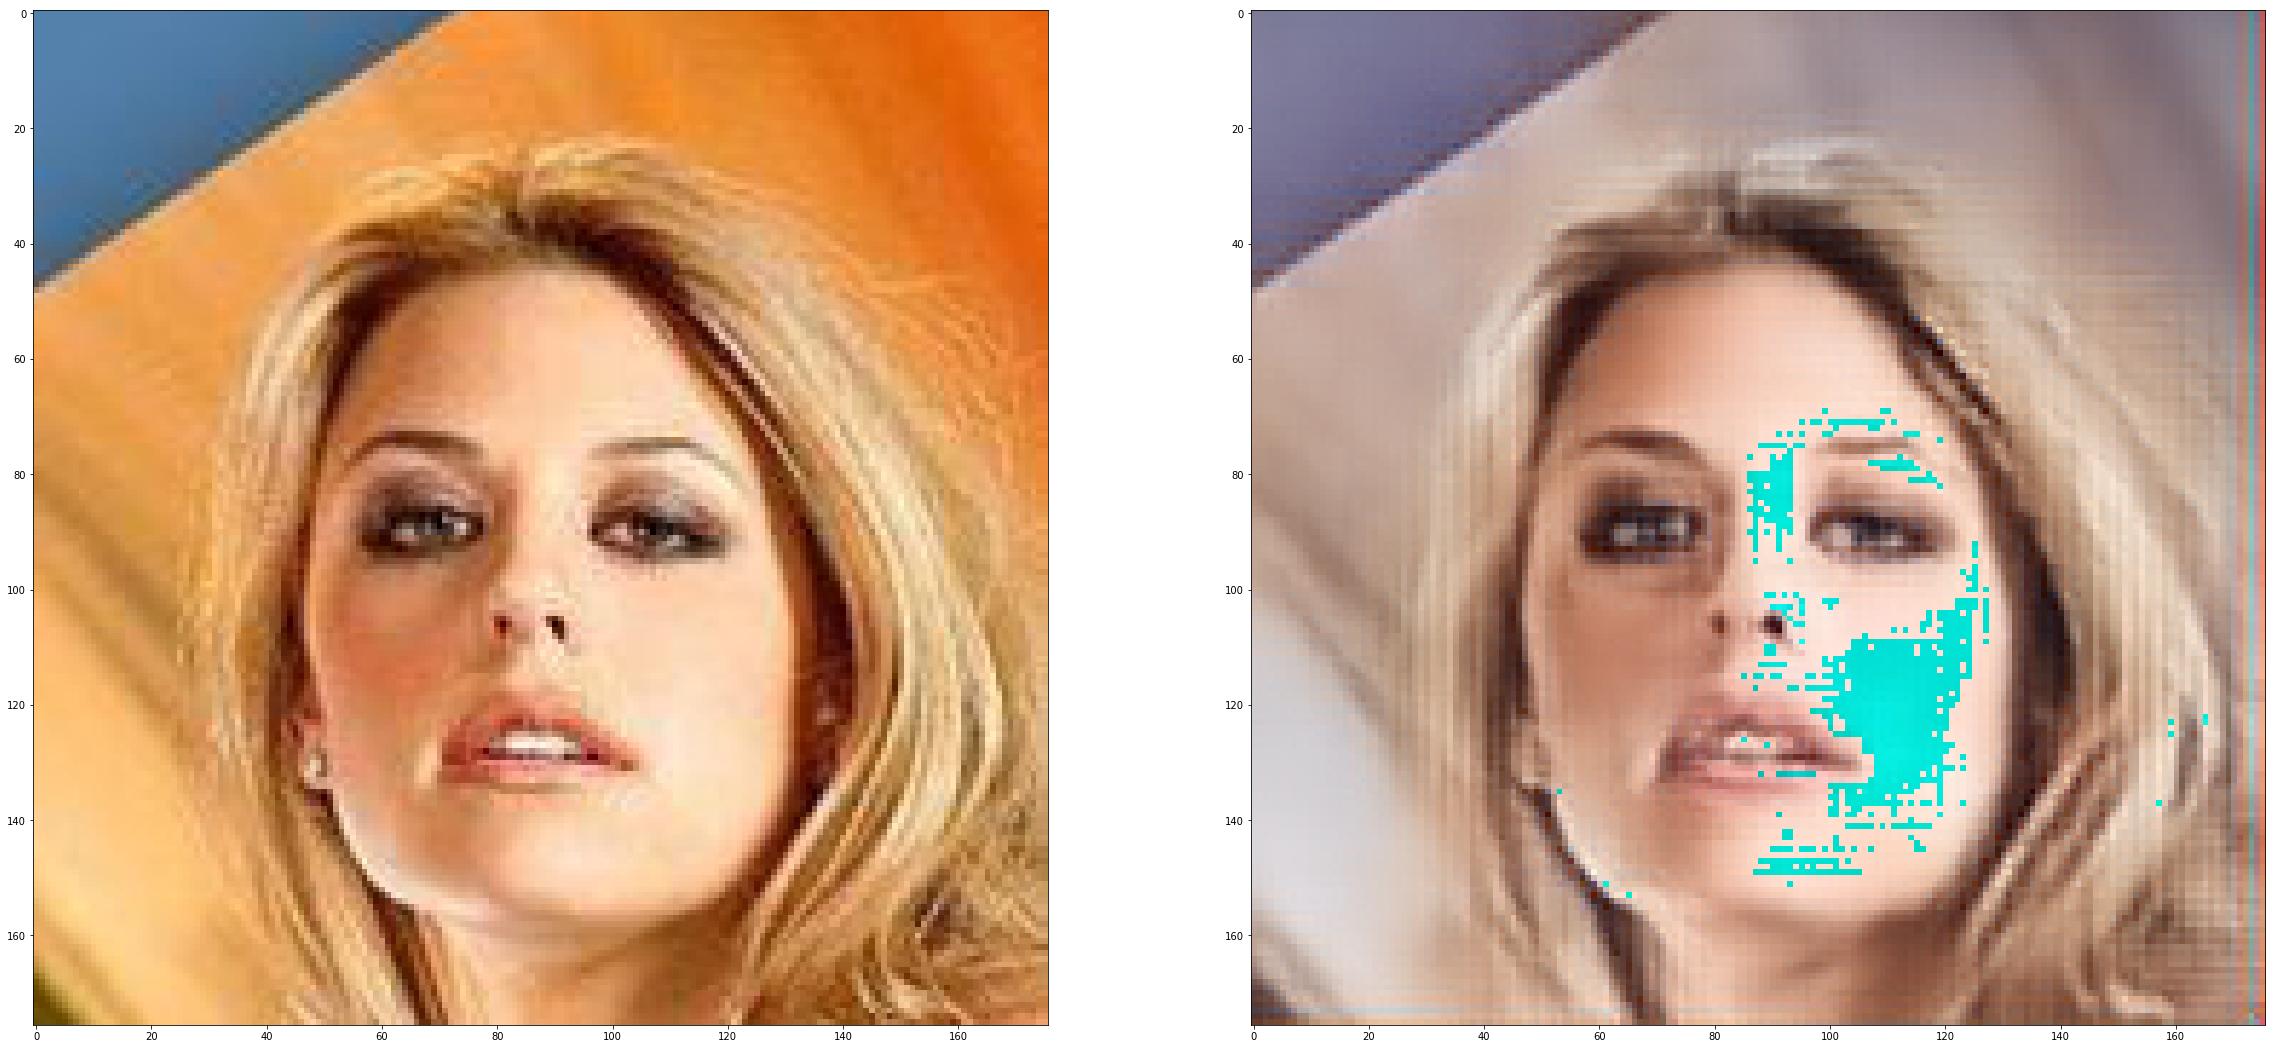

In [78]:
compare_pics(arr_color[23].astype('uint8'),p[23].astype('uint8'))

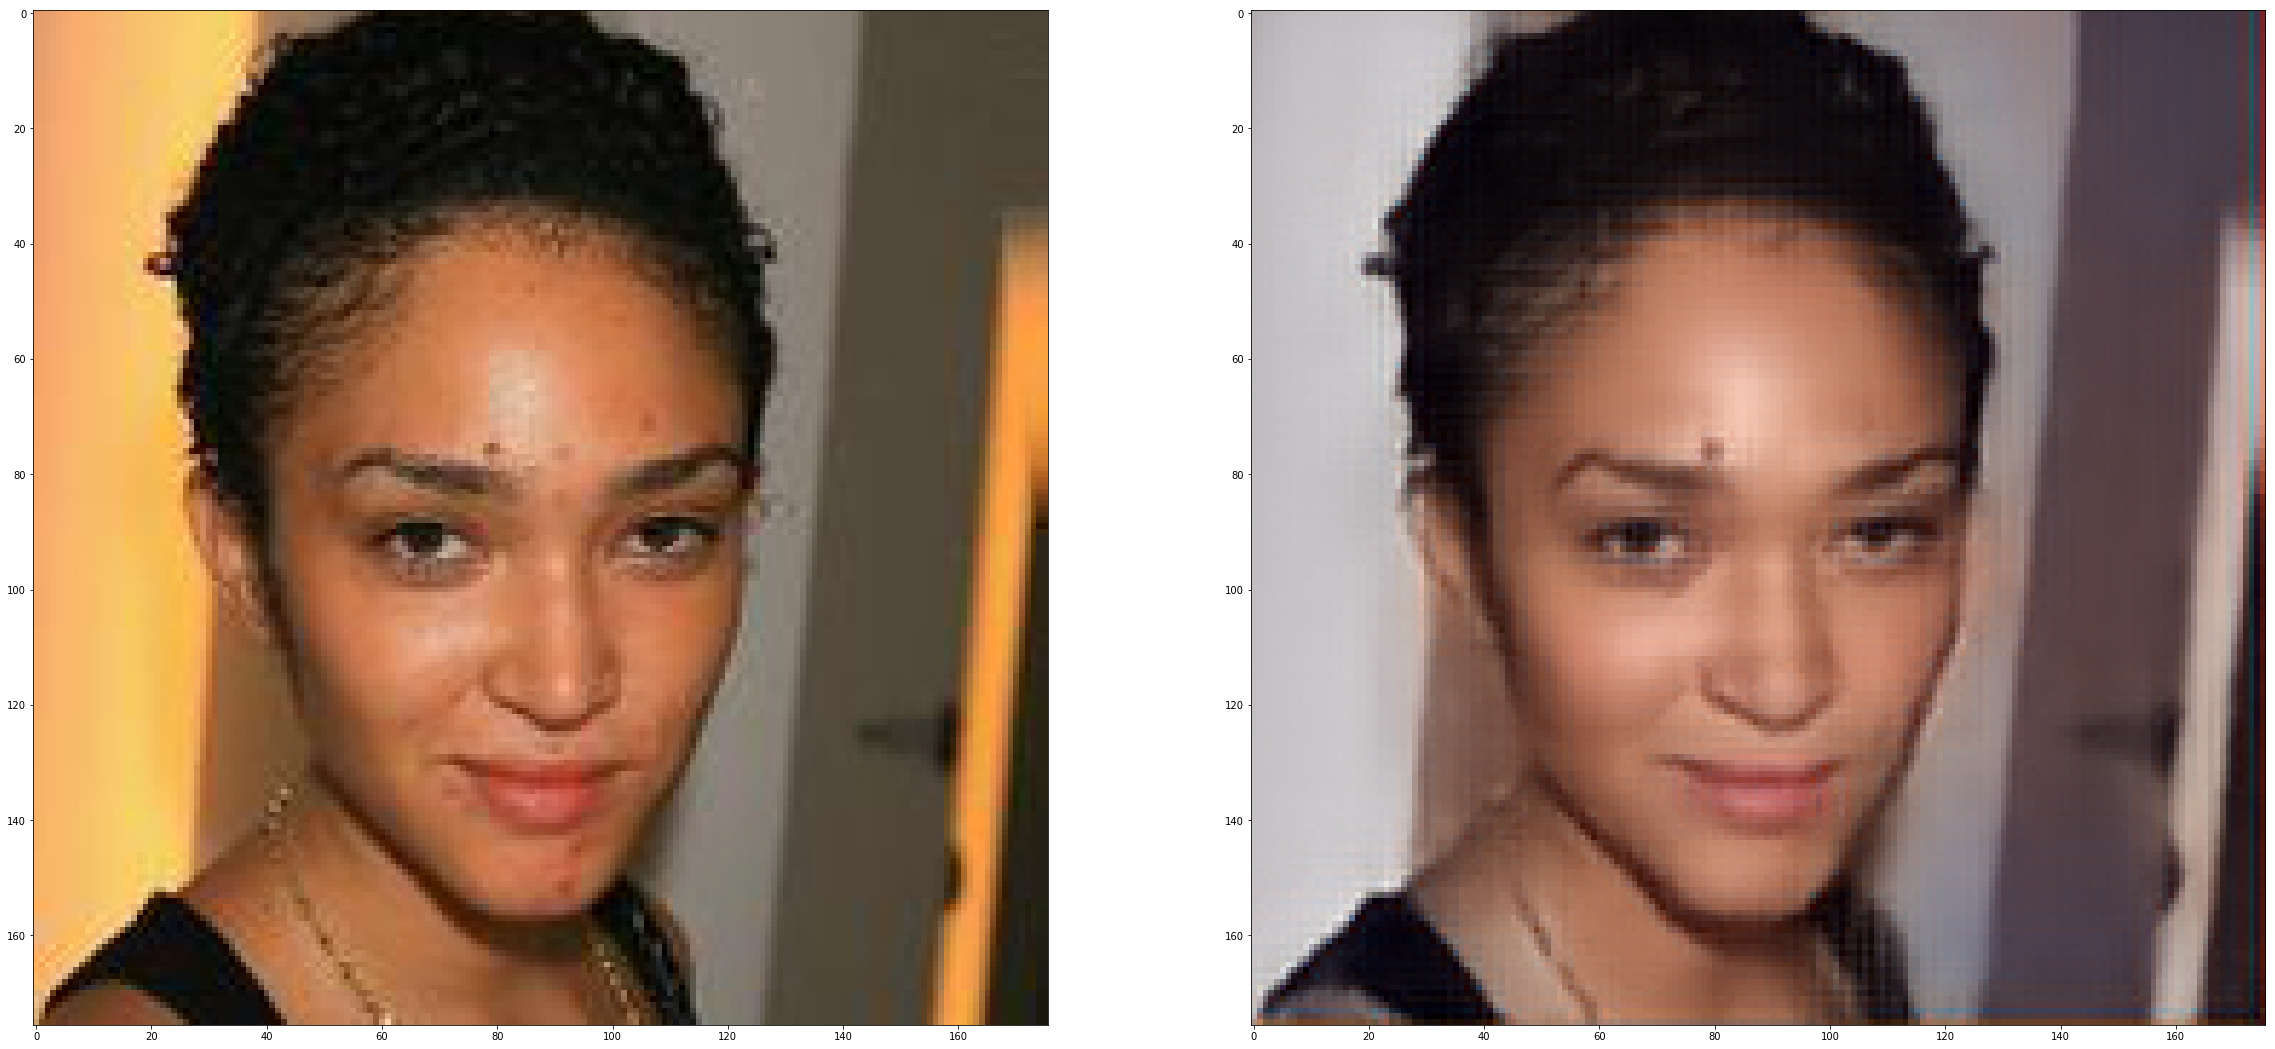

In [79]:
compare_pics(arr_color[13].astype('uint8'), p[13].astype('uint8'))

In [32]:
p = it_model.predict(arr_test_lr[0:50])
p.shape

NameError: name 'arr_test_lr' is not defined

In [ ]:
compare_pics(arr_test_lr[29].astype('uint8'),p[29].astype('uint8'))

In [ ]:
compare_pics(arr_test_hr[29].astype('uint8'),p[29].astype('uint8'))

In [ ]:
np = it_model.predict(p[0:50])
p.shape

In [ ]:
p.shape

In [ ]:
new_i,new_o = get_upsampling_model_4x(p[0:50].astype('uint8'))
    

In [ ]:
compare_pics(new_o[29].astype('uint8'),p[29].astype('uint8'))